In [37]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# download the dataset from the locally saved file
from google.colab import files

uploaded = files.upload()

df = pd.read_csv("kddcup99_csv.csv")
print(df.shape)
print(df.head())



Saving kddcup99_csv.csv to kddcup99_csv (1).csv
(494020, 42)
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2   

In [38]:
#check what the targets in the dataset look like
print(df.shape)
print(df.head())
print(len(df['label'].unique()))
print(df['label'].unique())
print(df['label'].value_counts())

(494020, 42)
   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        181       5450     0   
1         0           tcp    http   SF        239        486     0   
2         0           tcp    http   SF        235       1337     0   
3         0           tcp    http   SF        219       1337     0   
4         0           tcp    http   SF        217       2032     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   

We see from the output above that there are 41 features and 23 distinct label values in the subset of the dataset that is downloaded. Since logistic regression works on binary target, we will now split the targets into Probe - 1 (ipsweep, portsweep, nmap, satan) and Non-Probe - 0 for the rest

In [49]:
# Check the feature columns and the taget column

print(df.columns)

probe_attacks = ['ipsweep', 'nmap', 'portsweep', 'satan']

# separate the features from the labels
features = df.drop(columns = ['label', 'target'])
df['target'] = df['label'].apply(lambda x: 1 if x in probe_attacks else 0)

print(df['target'].value_counts())

#split the dataset into 80% training and 20% test using the stratify parameter to preserve proportions of non-probe and probe

X_train, X_test, y_train, y_test = train_test_split(features, df['target'], test_size=0.2)

print(len(X_train), len(X_test), len(y_train), len(y_test))
print("Number of features: ", len(X_train.columns))
print("Label counts for the training dataset:", y_train.value_counts())

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell',
       'lsu_attempted', 'lnum_root', 'lnum_file_creations', 'lnum_shells',
       'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'target'],
      dtype='object')
target
0    489913
1      4107
Name: count, dtype: int64
395216 98804 395216 98804
Number of features:  41
Label counts for the tra

From the counts printed above we se that the dataset is imbalanced as the Probe samples are less than 1% of all samples. We need to downsample the Non-Probe class so that the data is more balanced.

In [50]:
from imblearn.under_sampling import RandomUnderSampler

# Create the under-sampler
rus = RandomUnderSampler(random_state=42)
print("Before under-sampling:", y_train.value_counts())
# Apply it to the training set only
X_train, y_train = rus.fit_resample(X_train, y_train)

print("After under-sampling: ", y_train.value_counts())


Before under-sampling: target
0    391929
1      3287
Name: count, dtype: int64
After under-sampling:  target
0    3287
1    3287
Name: count, dtype: int64


Next we need to do some preprocessing of the data. Since Logistic Regression needs numerical inputs, we will have to convert the categorical features into numerical. The categorical columns are the ones listed as object type - protocol_type, service and flag.
For the numerical features we will apply StandardScaler from sklearn library and for the categorical columns use OneHotEncoder to encode them into numerical values

In [51]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = ['protocol_type', 'service', 'flag']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])



In [52]:
# build pipeline with Logistic Regression
# Note: regularization is applied by default by sklearn
# use penalty = None to turn it off


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=None, max_iter=1000))
])

# train
model.fit(X_train, y_train)

# evaluate
from sklearn.metrics import classification_report, confusion_matrix

# Using the trained model we can run it on the test data
y_pred = model.predict(X_test)
print("CONFUSION MATRIX: ")
print(confusion_matrix(y_test, y_pred))

#calculate accuracy
accuracy = model.score(X_train, y_train)
print(f"Training accuracy: {accuracy:.4f}")


CONFUSION MATRIX: 
[[97208   776]
 [    5   815]]
Training accuracy: 0.9944


In [53]:
# get the test accuracy

test_accuracy = model.score(X_test, y_test)
print(f"Testing accuracy: {test_accuracy:.4f}")

# number of iterations used
print("Iterations: ", model.named_steps['classifier'].n_iter_)

# print the coefficients
print(len(model.named_steps['classifier'].coef_[0]))
print(len(X_train.columns))

Testing accuracy: 0.9921
Iterations:  [112]
104
41


RESULTS SUMMARY: The confusion matrix shows that there were 97212 true negatives (i.e. non-Probe predicted correctly), 759 False Positives (Non-Probe predicted as Probe), 10 False Negatives and 825 True positives.
The training accuracy is 0.9944 and the testing accuracy is 0.9921. Since both are high, the model is **not overfitting**, even without regularization. It took 112 iterations for the model to converge.
We have 104 coefficients since we did the OneHotEncoding of the categorical columns, which added extra columns. The number of features is 41.

In [34]:
# add a function to analyze the coefficients and sort them by importance

def get_feature_importance(model, categorical_cols, numeric_cols):

    # Get fitted one-hot encoder
    ohe = model.named_steps['preprocessor'].named_transformers_['cat']

    # Get expanded categorical feature names
    ohe_features = ohe.get_feature_names_out(categorical_cols)

    # Combine with numeric feature names
    all_features = numeric_cols + list(ohe_features)

    # Extract coefficients (only one row since binary classification)
    coefs = model.named_steps['classifier'].coef_[0]

    # Build DataFrame
    coef_df = pd.DataFrame({
        'feature': all_features,
        'coefficient': coefs,
        'abs_coefficient': np.abs(coefs)
    })

    # Sort by absolute coefficient
    coef_df = coef_df.sort_values(by="abs_coefficient", ascending=False).reset_index(drop=True)
    return coef_df[['feature', 'coefficient']]

coef_df = get_feature_importance(model, categorical_cols, numeric_cols)
print(coef_df.head(20))

              feature  coefficient
0           flag_RSTR    59.802616
1           dst_bytes   -54.517207
2            flag_REJ   -44.638632
3       service_urp_i   -44.575477
4           flag_RSTO   -43.175317
5         flag_RSTOS0    39.120204
6       service_ntp_u   -29.097835
7    service_domain_u   -28.573256
8             flag_S0   -28.424736
9   service_hostnames    24.466767
10     is_guest_login   -23.939090
11            flag_SH    23.521478
12        service_rje    21.752287
13       service_uucp    20.598960
14        service_mtp    19.710269
15      service_whois    17.842813
16      service_eco_i    17.775883
17            flag_S2    17.347914
18                hot    16.623234
19      service_ecr_i    16.049247


**Analysis of model parameters**
The most important features the reset flags flag_RSTR (coefficient is 59.8) and flag_RSTOS0 (39.12) - these are the features most indicative of a Probe, which makes sense since a lot of port scanning techniques involve receiving TCP RST by the responder. Conversely, the features with lowest coefficients that least indicate of probe are flag_REJ and flag_RSTO - reset by originator

L2 training accuracy: 0.9929749541844838
L2 testing accuracy: 0.9876320796728877
L1 training accuracy: 0.9948075748320098
L1 testing accuracy: 0.9932593822112465


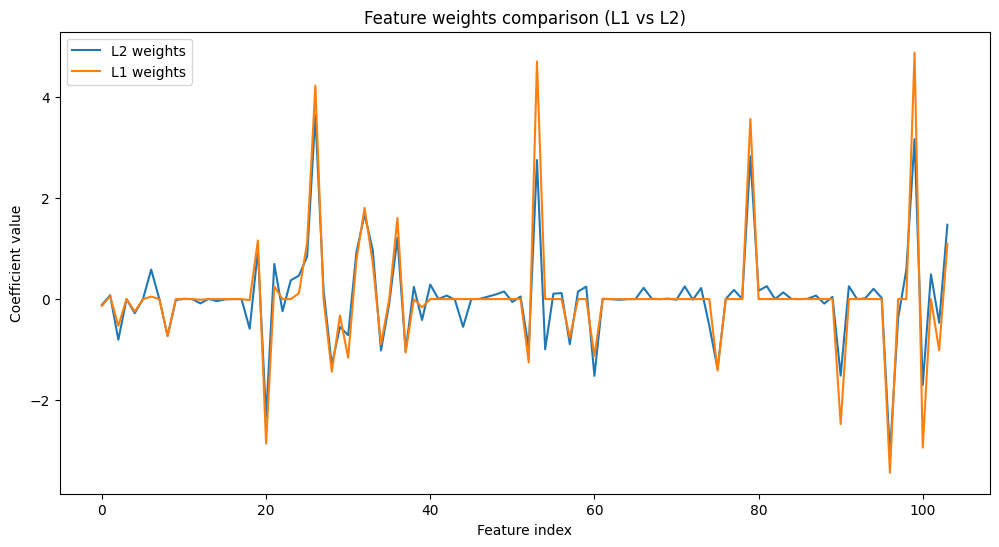

In [35]:
### Train with L2 and L1 regularization and compare
import matplotlib.pyplot as plt
# L2 regularization is applied by default, but specify explicitly for clarity
model_l2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000))
])
model_l2.fit(X_train, y_train)


# L1 - use solver='liblinear'
model_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])
model_l1.fit(X_train, y_train)

# compare accuracy
print("L2 training accuracy:", model_l2.score(X_train, y_train))
print("L2 testing accuracy:", model_l2.score(X_test, y_test))
print("L1 training accuracy:", model_l1.score(X_train, y_train))
print("L1 testing accuracy:", model_l1.score(X_test, y_test))

# feature names
feature_names = model_l2.named_steps['preprocessor'].get_feature_names_out()

# coefficients
coef_l2 = model_l2.named_steps['classifier'].coef_[0]
coef_l1 = model_l1.named_steps['classifier'].coef_[0]

# plot
plt.figure(figsize=(12,6))
plt.plot(coef_l2, label='L2 weights')
plt.plot(coef_l1, label='L1 weights')
plt.title("Feature weights comparison (L1 vs L2)")
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.legend()
plt.show()


**Analysis of L1 and L2 regularization results**

Both produced good training and testing accuracy, no overfitting, which is to be expected as results were good even without regularization.
The accuracies of L1 and L2 regularization are pretty similar.
As far as the weights, we can clearly see that The L1 weights tend to be much higher for certain features, while many other coefficients are being zeroed out, thus making the model simpler ans smaller. Overall, the importance of the features is preserved.
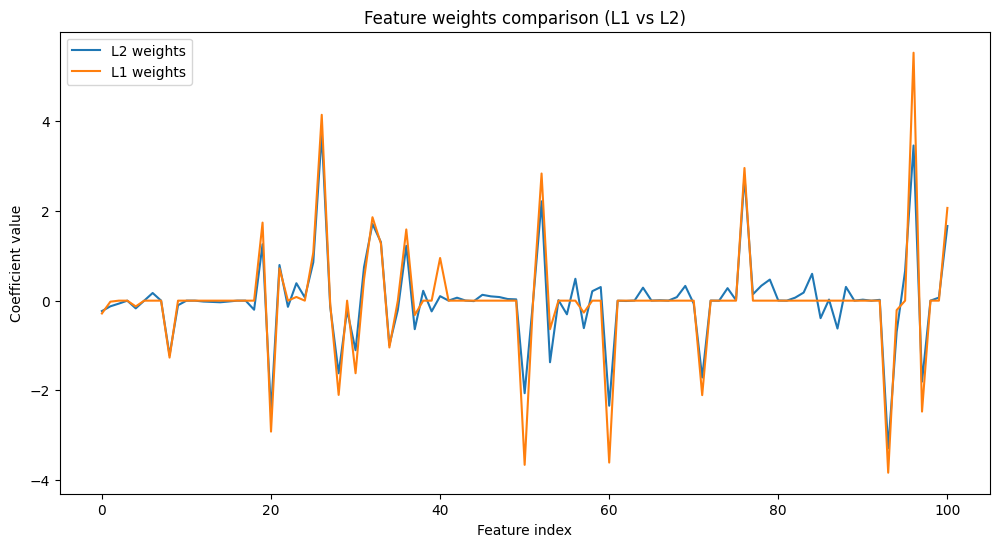

In [36]:
## Try different strengths of L2 regularization and compare training and test accuracy
## The sklearn LogisticRegression() parameter for strength is C which is the inverse of lambda
## smaller values of C correspond to stronger regularization, while for very large values it is
## almost eliminated

C_values = [0.001, 0.01, 0.1, 1, 10]
train_results = []
test_results = []

for C in C_values:
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=1000))
    ])
    model.fit(X_train, y_train)
    train_results.append(model.score(X_train, y_train))
    test_results.append(model.score(X_test, y_test))

# Print results
for C, tr, te in zip(C_values, train_results, test_results):
    print(f"C={C:<6}  train_acc={tr:.4f}  test_acc={te:.4f}")

C=0.001   train_acc=0.9623  test_acc=0.9289
C=0.01    train_acc=0.9843  test_acc=0.9773
C=0.1     train_acc=0.9885  test_acc=0.9820
C=1       train_acc=0.9930  test_acc=0.9876
C=10      train_acc=0.9962  test_acc=0.9932


Though the numbers are pretty similar, with very strong regularization (C=0.001) the accuracy for both training and testing is slighly lower. That makes sense as the heavily regularized model would have a problem fitting the data well.